# Simulation Notebook

7/9/18: Here, we want to analyze different simulations and the effect on the resulting fragility algorithm. We will perform this on one patient. 

In [1]:
import sys
sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/binmarcc/hpc_util/')
sys.path.append('/Users/adam2392/Documents/tvb/binmarcc/hpc_util/util/')

from tvb.simulator.lab import *
import os
import numpy as np
import pandas as pd
import argparse
import itertools

# wrapper for frequency analysis
import main_freq
from util_loader import load_data
from util_sim import shuffle_conn_patients, shuffle_conn_weights
from util_sim import save_processed_data,\
            initialize_tvb_model, \
            showdebug, select_ez_outside, \
            select_ez_inside, \
            run_freq_analysis

# to run simulation and post processing and data loading
from tvbsim.exp.utils.selectregion import Regions
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.maintvbexp import MainTVBSim

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler


   INFO  log level set to INFO


In [25]:
patient = 'id013_pg'
outputdatadir = os.path.expanduser('~/Downloads/tvbsim_exp/sim_output')
metadatadir = os.path.expanduser('~/Downloads/tngpipeline/_old/')
movedist = -1
shuffleweights = 0
typeshuffling = 'within'
numsims = 1
ezselectiontype = 'clin'

# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 45*_samplerate    
period = 1./_factor

# set all directories to output data, get meta data, get raw data
outputdatadir = os.path.join(outputdatadir, patient)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
rawdatadir = os.path.join(metadatadir, patient)

# define sloader for this patient
loader = load_data(patient, rawdatadir)

2018-07-11 00:59:25,452 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-07-11 00:59:25,452 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-07-11 00:59:25,473 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-07-11 00:59:25,473 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-07-11 00:59:25,488 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/_old/id013_pg/tvb/connectivity.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/_old/id013_pg/tvb/connectivity.zip
2018-07-11 00:59:25,599 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/_old/id013_pg/tvb/connectivity.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/_old/id013_pg/tvb/connectivity.zip
2018-07-11 00:59:2

In [28]:
shuffledpat = None
# perhaps shuffle connectivity?
if shuffleweights:
    print("shuffling weights!")
    if typeshuffling == 'within':
        conn = shuffle_conn_weights(loader.conn)
    elif typeshuffling == 'null':
        conn, shuffledpat = shuffle_conn_patients(loader.conn)

# extract the clinical hypothesized regions
clinezinds = loader.regezinds
clinpzinds = []
clinezregions = list(loader.conn.region_labels[clinezinds])
clinpzregions = []

# for i in range(numsims):
######## SET THE MODEL'S EZ AND PZ REGIONS ########
# get the ez/pz indices we want to use
if ezselectiontype == 'clin':
    modelezinds = clinezinds
    modelpzinds = []
    modelezregions = clinezregions
    modelpzregions = []
elif ezselectiontype == 'other':
    # if we are sampling regions outside our EZ
    numsamps = 2 # should be around 1-3?
    ######## SELECT EZ REGIONS INSIDE THE CLIN DEFINITIONS
    ezregs, ezinds = select_ez_inside(loader.conn, clinezregions, numsamps)
    modelezinds = ezinds
    modelpzinds = []
    modelezregions = ezregs
    modelpzregions = []
print("Model ez: ", modelezregions, modelezinds)
print("Model pz: ", modelpzregions, modelpzinds)

################################################################
#                   
#           SET UP MODEL 
#
################################################################
iext = 3.1
eps1 = -0.25
maintvbexp = initialize_tvb_model(loader, ezregions=modelezregions, 
            pzregions=modelpzregions, period=period, Iext=iext, eps1=eps1)
allindices = np.hstack((maintvbexp.ezind, maintvbexp.pzind)).astype(int) 


## OUTPUTFILE NAME ##
_metafilename = '{}_{}_{}_{}_default.json'.format(patient, 'cond=3', 'iext=3.1', 'eps1=-0.5')
filename = os.path.join(outputdatadir, _metafilename.replace('json', 'npz'))
metafilename = os.path.join(outputdatadir, _metafilename)
direc, simfilename = os.path.split(filename)

# move contacts if we wnat to
if movedist != -1:
    for ind in maintvbexp.ezind:
        new_seeg_xyz, elecindicesmoved = maintvbexp.move_electrodetoreg(ind, movedist)
        print(elecindicesmoved)
        print(maintvbexp.seeg_labels[elecindicesmoved])

('Model ez: ', ['Right-Hippocampus', 'Right-Amygdala', 'ctx-rh-entorhinal', 'ctx-rh-fusiform', 'ctx-rh-inferiortemporal', 'ctx-rh-middletemporal'], array([46, 47, 53, 54, 56, 62]))
('Model pz: ', [], [])
WARNING  File 'hemispheres' not found in ZIP.
Iext = 3.1
eps1 = -0.25
The tvbexp ez region is: ['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-entorhinal'
 'ctx-rh-fusiform' 'ctx-rh-inferiortemporal' 'ctx-rh-middletemporal']The tvbexp pz region is: NoneThe tvbexp ez indices is: [46 47 53 54 56 62]The tvbexp pz indices is: [] 

In [29]:
print(maintvbexp.epileptors.x0)

[-2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45
 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45
 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45
 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -1.7  -1.7
 -2.45 -2.45 -2.45 -2.45 -2.45 -1.7  -1.7  -2.45 -1.7  -2.45 -2.45 -2.45
 -2.45 -2.45 -1.7  -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45
 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45 -2.45]


In [30]:
metadata = maintvbexp.get_metadata()
print(maintvbexp.ezregion)
print(maintvbexp.pzregion)
print(metadata.keys())
print(metadata['condspeed'], metadata['x0ez'], metadata['x0pz'])

['Right-Hippocampus' 'Right-Amygdala' 'ctx-rh-entorhinal'
 'ctx-rh-fusiform' 'ctx-rh-inferiortemporal' 'ctx-rh-middletemporal']
None
['condspeed', 'gainmat', 'x0norm', 'goodchaninds', 'x0pz', 'ezregs', 'pzindices', 'pzregs', 'ezindices', 'chanlabels', 'regions_centers', 'regions', 'chanxyz', 'x0ez']
(array([3.]), None, None)


In [31]:
######################## run simulation ########################
configs = maintvbexp.setupsim()
times, statevars_ts, seegts = maintvbexp.mainsim(sim_length=sim_length)

In [32]:
######################## POST PROCESSING ########################
postprocessor = PostProcessor(samplerate=_samplerate, allszindices=allindices)
secstoreject = 15
times, epits, seegts, zts, state_vars = postprocessor.postprocts(statevars_ts, seegts, times, secstoreject=secstoreject)
# save all the raw simulated data
save_processed_data(filename, times, epits, seegts, zts, state_vars)

# GET ONSET/OFFSET OF SEIZURE
detector = DetectShift()
settimes = detector.getonsetsoffsets(epits, allindices)
seizonsets, seizoffsets = detector.getseiztimes(settimes)
print("The detected onset/offsets are: {}".format(zip(seizonsets,seizoffsets)))

# save metadata from the exp object and from here
metadata = maintvbexp.get_metadata()
metadata['patient'] = patient
metadata['samplerate'] = _samplerate
metadata['simfilename'] = simfilename
metadata['clinez'] = clinezregions
metadata['clinpz'] = clinpzregions
metadata['onsettimes'] = seizonsets
metadata['offsettimes'] = seizoffsets
metadata['shuffledpat'] = shuffledpat

# save metadata
loader._writejsonfile(metadata, metafilename)

finished simulating!
/Users/adam2392/Downloads/tvbsim_exp/sim_output/id013_pg_cond=3_iext=3.1_eps1=-0.5_default.npz
(84, 30000)
(59, 30000)
(30000,)
(84, 30000)
['x2', 'y1', 'x1', 'y2', 'g']
[  141.   217.   271.  4235.  5730.  6969. 10528. 13863. 14461. 17251.
 19588. 20949. 26072.]
[ 3724.  2852.  3454.  9549.  7699. 12734. 12909. 18055. 20530. 20173.
 26204. 21857.    nan]
returning cuz prevoffset is nan!
The detected onset/offsets are: [(141.0, 3724.0), (4235.0, 12909.0)]


# Plotting Raw Epileptor

In [33]:
from tvbsim.visualize.old import plotts
import json
import io
import tvbsim

In [34]:
outputdatadir = os.path.expanduser('~/Downloads/tvbsim_exp/sim_output')
patient = 'id013_pg'

with io.open(os.path.join(outputdatadir, patient, _metafilename),  #"{}_cond=3_default.json".format(patient)), 
             encoding="utf8") as f:
    metadata = json.load(f)
print(metadata.keys())

simfilename = metadata['simfilename']

datastruct = np.load(os.path.join(outputdatadir, patient, simfilename))
epits = datastruct['epits']
region_labels = np.array(metadata['regions'])
modelezinds = metadata['ezindices']
modelpzinds = metadata['pzindices']

[u'condspeed', u'x0pz', u'clinpz', u'ezregs', u'pzindices', u'patient', u'samplerate', u'simfilename', u'chanlabels', u'clinez', u'regions', u'offsettimes', u'chanxyz', u'onsettimes', u'gainmat', u'x0norm', u'goodchaninds', u'ezindices', u'pzregs', u'regions_centers', u'shuffledpat', u'x0ez']


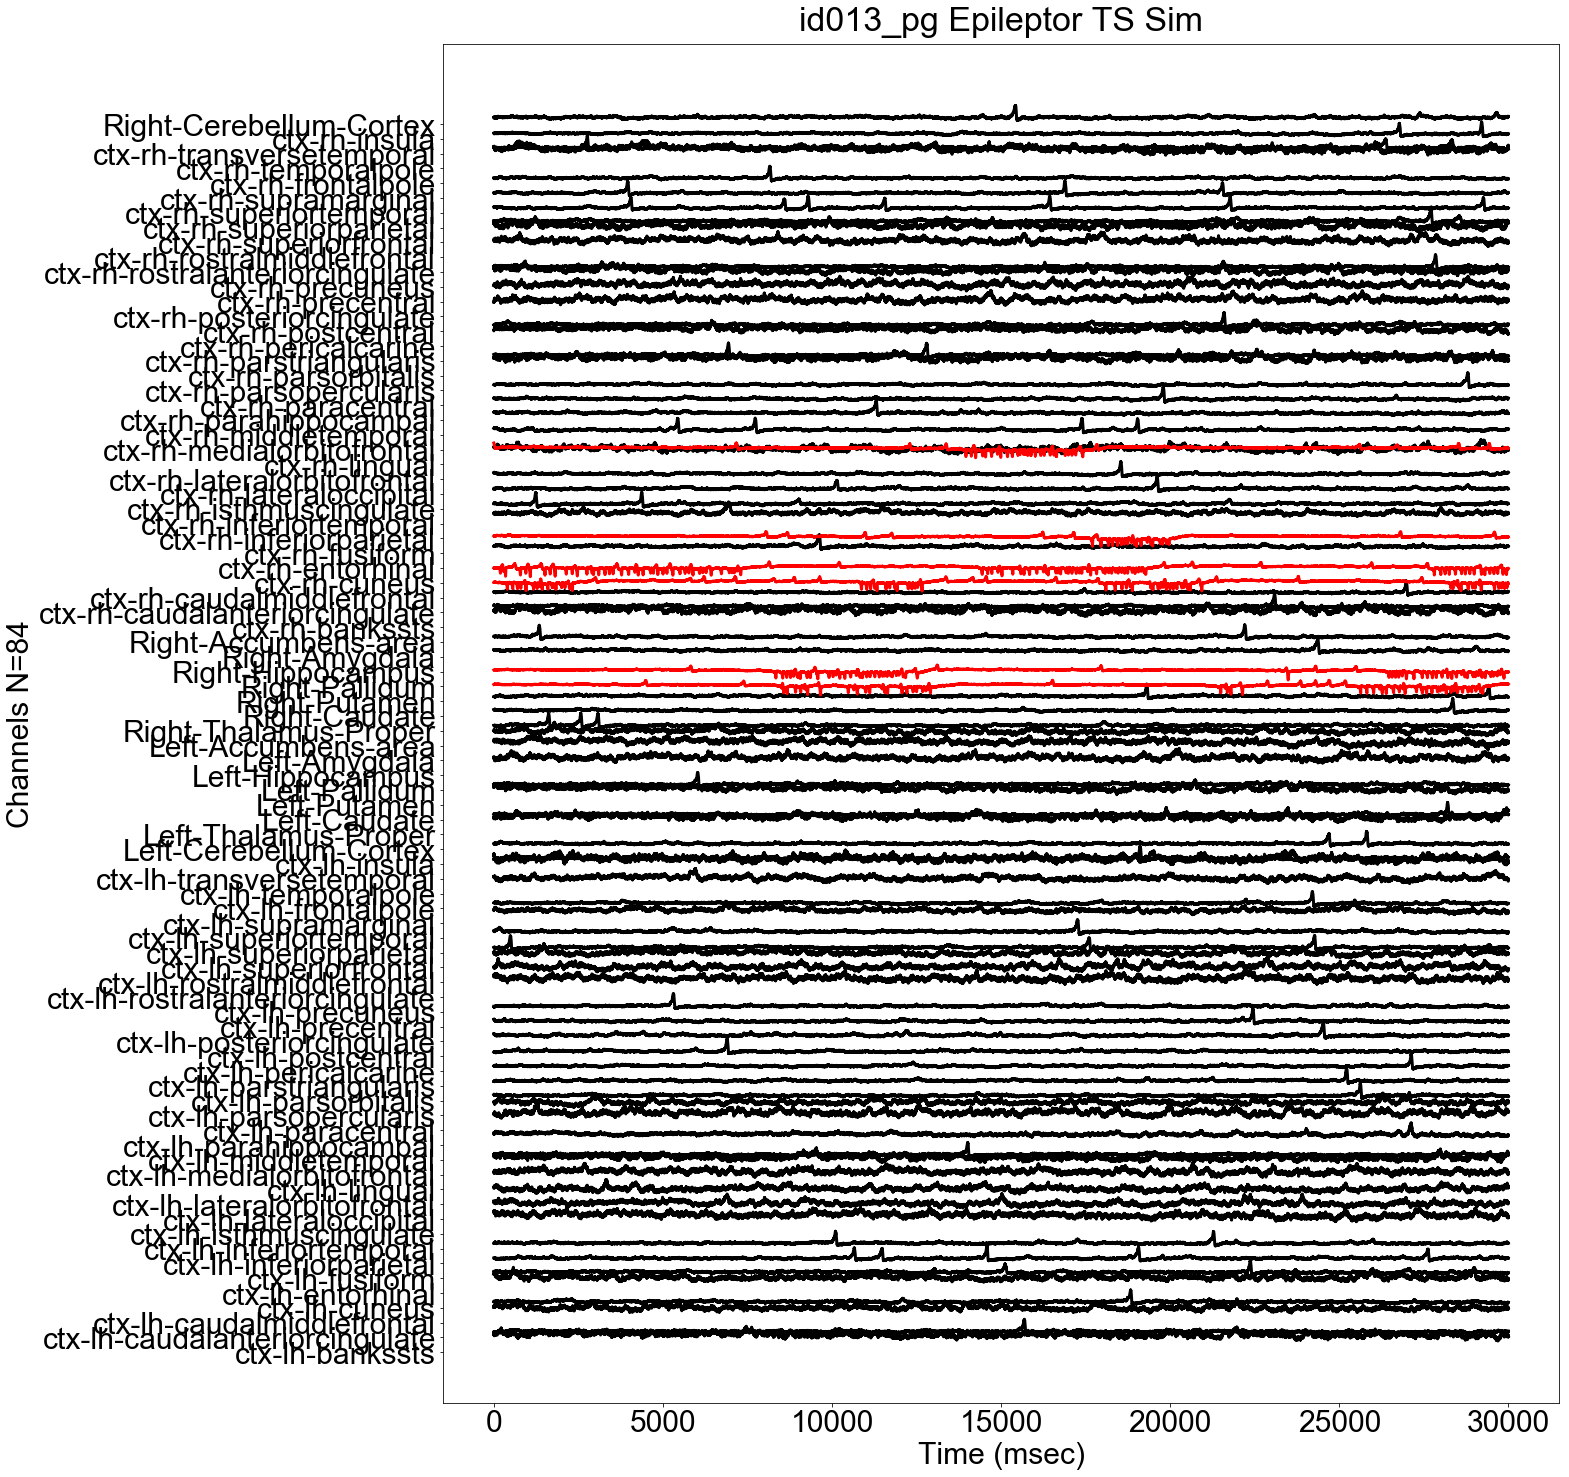

In [35]:
tsviz = tvbsim.visualize.old.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=region_labels)
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True, titlestr='{} Epileptor TS Sim'.format(patient))
# tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(modelezinds, color='red')
tsviz.colorts(modelpzinds, color='blue')